
<img src="../../img/ods_stickers.jpg">

## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 
    
Авторы материала: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 7 (демо)
## <center> Обучение без учителя: метод главных компонент и кластеризация

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачайте данные [отсюда](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице. 

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации. 

Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1qzcrfsNFy-e4TW59v2fqMj_OTom2SIOxtq4MWlI92p0).

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [3]:
X_train = np.loadtxt("X_train.txt")
y_train = np.loadtxt("y_train.txt").astype(int)

X_test = np.loadtxt("X_test.txt")
y_test = np.loadtxt("y_test.txt").astype(int)

In [4]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*. 

In [5]:
# Ваш код здесь
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))
X.shape, y.shape

((10299, 561), (10299,))

Определим число уникальных значений меток целевого класса.

In [6]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [7]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [8]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [33]:
# Ваш код здесь
pca = PCA(0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

In [10]:
X_pca.shape

(10299, 65)

**Вопрос 1:**<br>
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

In [14]:
len(pca.components_)

65

**Варианты:**
- 56 
- 65
- 66
- 193

**Вопрос 2:**<br>
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов. 

**Варианты:**
- 45
- 51
- 56
- 61

In [16]:
pca.explained_variance_ratio_[0]

0.5073822103501333

In [25]:
pca.explained_variance_ratio_

array([0.50738221, 0.06239186, 0.02692564, 0.02452871, 0.01888936,
       0.01631395, 0.01414533, 0.01216211, 0.00985248, 0.00949228,
       0.00858304, 0.0080998 , 0.00765863, 0.00676668, 0.00630242,
       0.00615718, 0.00595335, 0.00577195, 0.00563431, 0.0054083 ,
       0.00518828, 0.00502742, 0.00473229, 0.00463818, 0.00446848,
       0.00439868, 0.00416863, 0.00400809, 0.00389072, 0.00381339,
       0.0036687 , 0.00364357, 0.00349225, 0.00346736, 0.00335539,
       0.00329411, 0.00323824, 0.00300508, 0.00294254, 0.00290452,
       0.00275765, 0.00269864, 0.00264196, 0.0025803 , 0.00255031,
       0.00247776, 0.00245537, 0.0023829 , 0.00235902, 0.00232044,
       0.0022836 , 0.00219182, 0.00212631, 0.00209145, 0.0020348 ,
       0.00201167, 0.00198111, 0.00194391, 0.00192509, 0.00189539,
       0.00186403, 0.00182923, 0.00180956, 0.00176364, 0.00174188])

In [58]:
pca01 = np.array([pca.explained_variance_ratio_[0], pca.explained_variance_ratio_[1]])
pca01

array([0.50738221, 0.06239186])

In [59]:
pca_componenets01 = np.array([[pca.components_[0, 0], pca.components_[0, 1]], [pca.components_[1, 0], pca.components_[1, 1]]])
pca_componenets01

array([[ 0.00032202, -0.00265502],
       [ 0.01667862,  0.00050924]])

Визуализируйте данные в проекции на первые две главные компоненты.

Proportion of variance explained by each component:
1st component - 0.51,
2nd component - 0.06

Directions of principal components:
1st component: [ 0.00032202 -0.00265502] 
2nd component: [0.01667862 0.00050924]


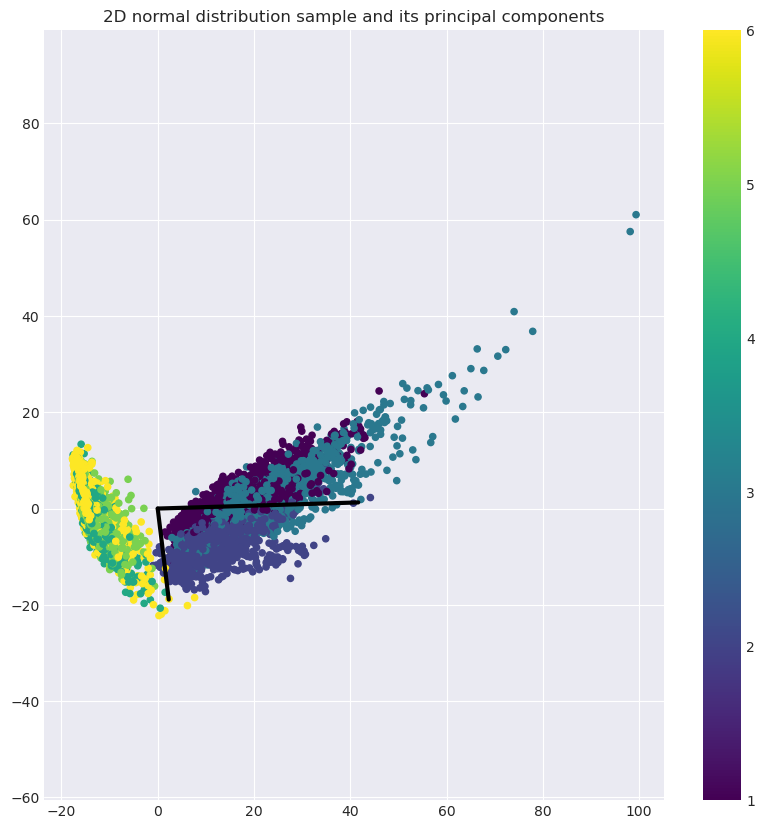

In [79]:
print('Proportion of variance explained by each component:\n' +\
      '1st component - %.2f,\n2nd component - %.2f\n' %
      tuple(pca01)) #процент дисперсии, который приходится на каждое направление
print('Directions of principal components:\n' +\
      '1st component:', pca_componenets01[0],
      '\n2nd component:', pca_componenets01[1])

plt.figure(figsize=(10,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis');
for l, v in zip(pca01, pca_componenets01):
    d = 10000 * np.sqrt(l) * v
    plt.plot([0, d[0]], [0, d[1]], '-k', lw=3)
plt.axis('equal')
plt.title('2D normal distribution sample and its principal components')
plt.colorbar()
plt.show()


**Вопрос 3:**<br>
Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [17]:
from sklearn.neighbors import KNeighborsClassifier

first_kmeans=KMeans(n_clusters = n_classes, random_state = RANDOM_STATE) #экземпляр класса Kmeans
first_kmeans.fit(X_pca, y_train)

KMeans(n_clusters=6, random_state=17)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

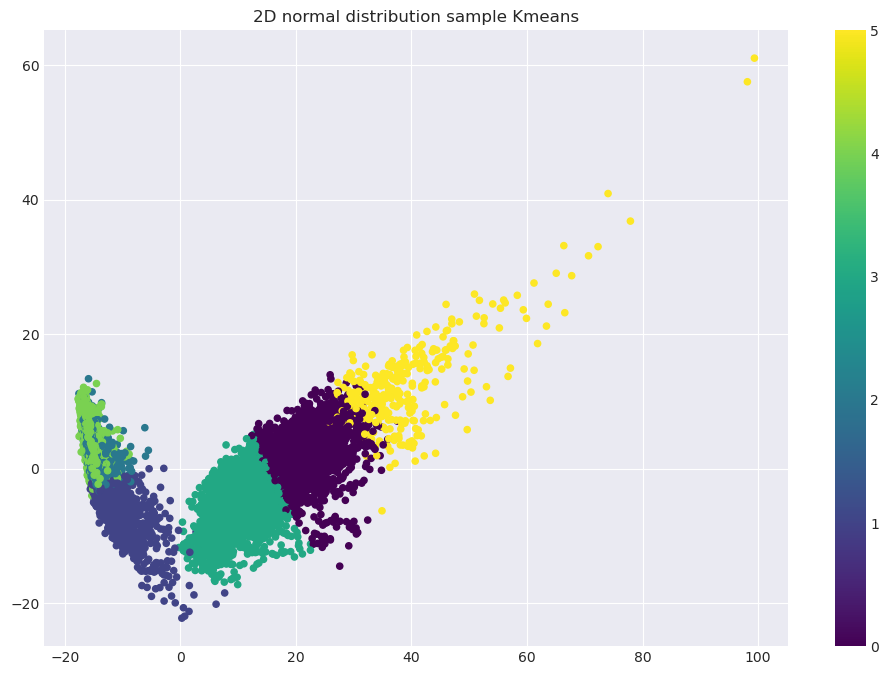

In [82]:
# Visualizing using 2 features: Total points vs. Total assists
plt.figure(figsize=(12,8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=first_kmeans.labels_, s=20, cmap='viridis')
plt.title('2D normal distribution sample Kmeans')
plt.colorbar()
plt.show()
#plt.scatter(, , c=cluster_labels, s=20,  cmap='viridis');

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [84]:
tab = pd.crosstab(y, first_kmeans.labels_, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,739,0,0,898,0,85,1722
подъем вверх по лестнице,295,2,0,1238,0,9,1544
спуск по лестнице,882,0,0,310,0,214,1406
сидение,0,449,1236,1,91,0,1777
стояние,0,562,1344,0,0,0,1906
лежание,0,329,52,5,1558,0,1944
все,1916,1342,2632,2452,1649,308,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации. 

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,
 
то такая доля будет 900 / 1406 $\approx$ 0.64.
 

**Вопрос 4:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- перечисленные варианты не подходят

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

In [89]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, random_state = RANDOM_STATE).fit(X)
    kmeanModel.fit(X)
  
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

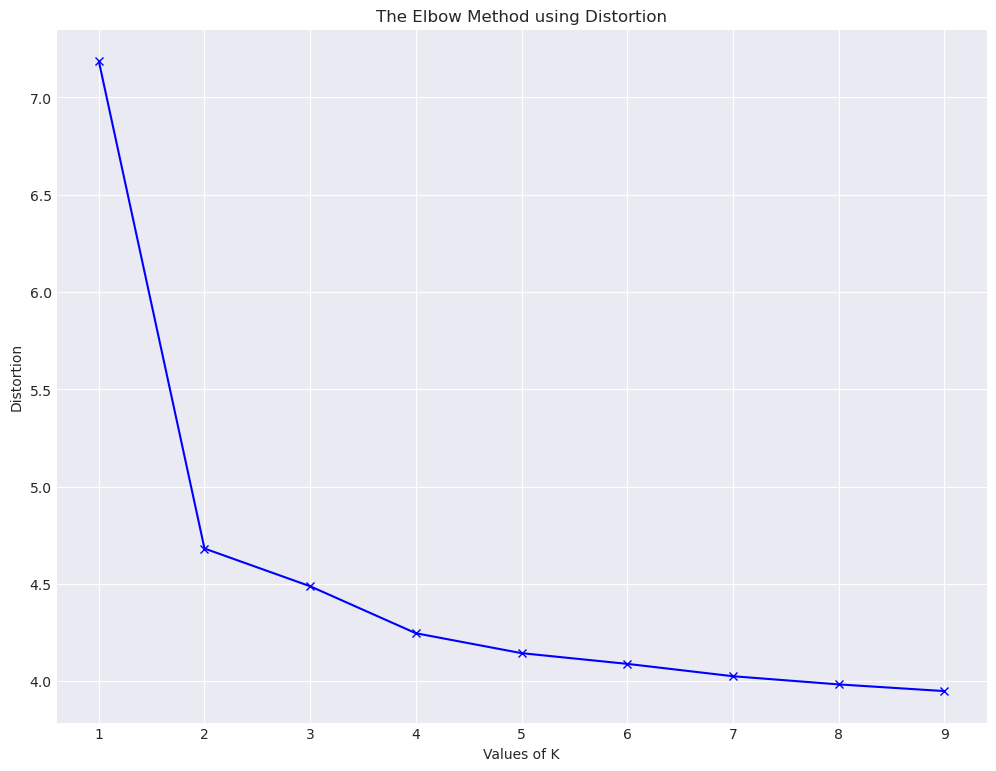

In [93]:
plt.plot(K, distortions, 'bx-')

plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()


**Вопрос 5:**<br>
Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [11]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit(X_pca)

In [14]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(ag.labels_, y)

0.49362763373004886

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [18]:
adjusted_rand_score(first_kmeans.labels_, y)

0.420052557165744

**Вопрос 6:**<br>
Отметьте все верные утверждения.<br>

**Варианты:**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf). 

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`. 

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [24]:
from sklearn.svm import LinearSVC

scaler_new = StandardScaler()

X_train_scaled = scaler_new.fit_transform(X_train)
X_test_scaled = scaler_new.fit_transform(X_test)

In [25]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [27]:
# Ваш код здесь
best_svc = GridSearchCV(svc, svc_params, cv=3, n_jobs=-1)

In [28]:
best_svc.fit(X_train, y_train)

C:\Users\ivan\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=3, estimator=LinearSVC(random_state=17), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [29]:
best_svc.best_estimator_

LinearSVC(C=1, random_state=17)

**Вопрос 7**<br>
Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- 0.1
- 1
- 10

In [30]:
y_predicted = best_svc.predict(X_test_scaled)

In [31]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,389,55,9,19,24,0,496
подъем вверх по лестнице,0,465,1,5,0,0,471
спуск по лестнице,0,13,373,11,23,0,420
сидение,2,5,0,352,131,1,491
стояние,2,2,0,11,517,0,532
лежание,0,0,1,33,9,494,537
все,393,540,384,431,704,495,2947


**Вопрос 8:**<br>
Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- по точности – сидение, по полноте – стояние

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

In [35]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

100 principal components explain 97.29% of variance


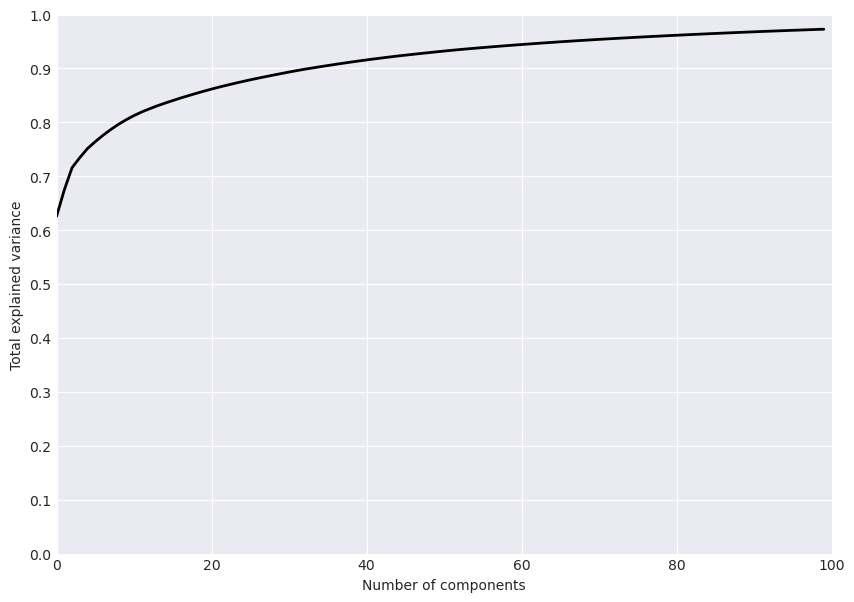

In [46]:
pca = PCA(n_components=100, svd_solver='randomized')
pca.fit(X_train)

print('100 principal components explain %.2f%% of variance' %
      (100 * np.cumsum(pca.explained_variance_ratio_)[-1]))
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), lw=2, color='k')
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 100)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

In [50]:
pca_params = {'n_components': np.arange(X.shape[1])}
best_pca = GridSearchCV(pca, pca_params, cv=3, n_jobs=-1)

In [51]:
best_pca.fit(X_train_pca, y_train)

C:\Users\ivan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
1581 fits failed out of a total of 1683.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ivan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ivan\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 382, in fit
    self._fit(X)
  File "C:\Users\ivan\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 459, in _fit
    return self._fit_truncated(X, n_components, self._fit_svd_solver)
  File "C:\Users\ivan\a

GridSearchCV(cv=3, estimator=PCA(n_components=100, svd_solver='randomized'),
             n_jobs=-1,
             param_grid={'n_components': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80...
       468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480,
       481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493,
       494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506,
       507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519,
       520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532,
       533, 534, 535, 536, 537, 538, 539, 

In [52]:
best_pca.best_estimator_

PCA(n_components=14, svd_solver='randomized')

**Вопрос 9:**<br>
Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4% 
- 10%
- 20%


In [57]:
pca_all = PCA(1, random_state=RANDOM_STATE)
X_pca_all = pca_all.fit_transform(X_scaled)
pca_all.explained_variance_ratio_

array([0.50738221])

**Вопрос 10:**<br>
Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком